In [1]:
from common import *
import logging
from glob import glob
from tqdm import tqdm

from nltk.tokenize import sent_tokenize

from joblib import Parallel, delayed
import multiprocessing
import json
import gzip

DATA_FOLDER = '../data/'
cpu_count = multiprocessing.cpu_count()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
class DocumentExtractor(object):
    def __init__(self, doc_list):
        self.doc_list = doc_list
 
    def __iter__(self):
        for fn in tqdm(self.doc_list):
            text = open(fn).read()
            document = []
            for sentence in sent_tokenize(text):
                document.append(tokenize(sentence))
            yield document
            
def save_documents(doc_list, prefix):
    docs = list(DocumentExtractor(doc_list))
    
    fname = join(DATA_FOLDER, 'documents/%s' % prefix + '.json.gz')
    with gzip.GzipFile(fname, 'w') as fout:
        json_str = json.dumps(docs)
        json_bytes = json_str.encode('utf-8')
        
        fout.write(json_bytes)

In [3]:
all_docs = get_all_docs(DATA_FOLDER)

In [5]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(save_documents)(list_block, i) for 
                  i, list_block in enumerate(grouper(len(all_docs)//1000, all_docs)) ) 
result = parallelizer( tasks_iterator )

100%|██████████| 1194/1194 [00:02<00:00, 444.32it/s]

100%|██████████| 1194/1194 [00:02<00:00, 530.11it/s]

 70%|███████   | 836/1194 [00:02<00:00, 390.16it/s]]


100%|██████████| 1194/1194 [00:11<00:00, 100.63it/s]


100%|██████████| 1194/1194 [00:01<00:00, 903.99it/s]


100%|██████████| 670/670 [00:04<00:00, 148.96it/s]


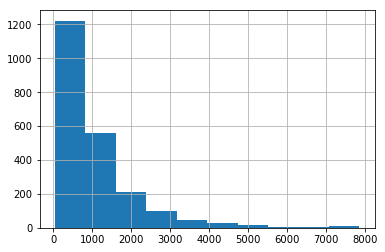

count     2217.000000
mean      1179.438881
std       1420.098309
min         41.000000
25%        490.000000
50%        748.000000
75%       1355.000000
max      20650.000000
dtype: float64

In [4]:
df = pd.Series([sum([len(s) for s in doc]) for doc in docs])

df[df<8000].hist()
plt.show()
df.describe()